# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets)

# Import Statements

In [1]:
%load_ext cudf.pandas
# get_ipython().kernel.do_shutdown(restart=True)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

# Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [4]:
data = pd.read_csv('cost_revenue.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [5]:
data.shape

(6000, 6)

In [6]:
data.replace('Unknown', np.nan, inplace=True)

In [7]:
data.isna().values.any()

True

In [8]:
data.dropna(inplace=True)

In [9]:
data.duplicated().values.any()

False

In [10]:
data.head()

,Unnamed: 0,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
0,0,"Jan 31, 2024",Argylle,"$200,000,000","$45,207,275","$96,214,128"
1,1,"Sep 4, 2020",Mulan,"$200,000,000",$0,"$69,973,540"
2,2,"Jul 2, 2021",The Tomorrow War,"$200,000,000",$0,"$19,220,000"
3,3,"Jul 13, 2022",The Gray Man,"$200,000,000",$0,"$451,178"
4,4,"Jun 29, 2011",Transformers: Dark of the Moon,"$195,000,000","$352,390,543","$1,123,794,079"


In [11]:
data.columns

Index(['Unnamed: 0', 'Release_Date', 'Movie_Title', 'USD_Production_Budget',
       'USD_Domestic_Gross', 'USD_Worldwide_Gross'],
      dtype='object')

In [12]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [13]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 5924 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Release_Date           5924 non-null   object
 1   Movie_Title            5924 non-null   object
 2   USD_Production_Budget  5924 non-null   object
 3   USD_Domestic_Gross     5924 non-null   object
 4   USD_Worldwide_Gross    5924 non-null   object
dtypes: object(5)
memory usage: 532.0+ KB


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [14]:
data.head()

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
0,"Jan 31, 2024",Argylle,"$200,000,000","$45,207,275","$96,214,128"
1,"Sep 4, 2020",Mulan,"$200,000,000",$0,"$69,973,540"
2,"Jul 2, 2021",The Tomorrow War,"$200,000,000",$0,"$19,220,000"
3,"Jul 13, 2022",The Gray Man,"$200,000,000",$0,"$451,178"
4,"Jun 29, 2011",Transformers: Dark of the Moon,"$195,000,000","$352,390,543","$1,123,794,079"


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [15]:
data["Release_Date"]=pd.to_datetime(data["Release_Date"],errors='coerce')
data.info()
# data.head()

<class 'cudf.core.dataframe.DataFrame'>
Index: 5924 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Release_Date           5924 non-null   datetime64[ns]
 1   Movie_Title            5924 non-null   object
 2   USD_Production_Budget  5924 non-null   object
 3   USD_Domestic_Gross     5924 non-null   object
 4   USD_Worldwide_Gross    5924 non-null   object
dtypes: datetime64[ns](1), object(4)
memory usage: 488.1+ KB


In [16]:
columns_to_clean=['USD_Production_Budget','USD_Worldwide_Gross',"USD_Domestic_Gross"]
for col in columns_to_clean:        
    data[col]=data[col].str.replace(r"[^0-9]+",'',regex=True)
    data[col]=pd.to_numeric(data[col])
data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 5924 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Release_Date           5924 non-null   datetime64[ns]
 1   Movie_Title            5924 non-null   object
 2   USD_Production_Budget  5924 non-null   int64
 3   USD_Domestic_Gross     5924 non-null   int64
 4   USD_Worldwide_Gross    5924 non-null   int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 343.9+ KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [17]:
data.describe()

,Release_Date,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
count,5924,"5,924.00","5,924.00","5,924.00"
mean,2005-11-15 03:09:21.512491648,"31,988,163.34","41,348,027.41","89,119,463.29"
min,1925-12-30 00:00:00,"650,000.00",0.00,0.00
25%,2000-10-13 00:00:00,"7,000,000.00","2,457,491.25","6,466,687.50"
50%,2008-02-25 12:00:00,"19,000,000.00","18,862,845.50","31,844,109.50"
75%,2014-09-19 00:00:00,"41,000,000.00","53,359,312.50","101,141,070.75"
max,2026-10-15 00:00:00,"200,000,000.00","718,732,821.00","1,511,986,364.00"
std,None,"36,825,409.29","61,941,254.08","153,184,647.72"


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [18]:
zero_domestic=data[data["USD_Domestic_Gross"]==0]

In [19]:
zero_domestic.sort_values(by="USD_Production_Budget",ascending=False)

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
1,2020-09-04,Mulan,200000000,0,69973540
2,2021-07-02,The Tomorrow War,200000000,0,19220000
3,2022-07-13,The Gray Man,200000000,0,451178
101,2019-11-01,The Irishman,159000000,0,914706
160,2021-11-04,Red Notice,150000000,0,173638
...,...,...,...,...,...
5981,2009-04-07,Bled,750000,0,0
5982,2016-01-05,Adulterers,750000,0,0
5983,2019-01-04,Rust Creek,750000,0,0
5992,2010-01-26,B-Girl,700000,0,1160


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [20]:
# data.loc[data["USD_Worldwide_Gross"]==0]
zero_world=data[data["USD_Worldwide_Gross"]==0]

In [21]:
zero_world.sort_values(by="USD_Production_Budget",ascending=False)

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
161,2024-07-03,Beverly Hills Cop: Axel F,150000000,0,0
162,2019-12-13,6 Underground,150000000,0,0
281,2018-11-09,Outlaw King,120000000,0,0
282,2022-12-02,Emancipation,120000000,0,0
294,2019-03-06,Triple Frontier,115000000,0,0
...,...,...,...,...,...
5968,2006-09-08,Iraq for Sale: The War Profiteers,775000,0,0
5981,2009-04-07,Bled,750000,0,0
5982,2016-01-05,Adulterers,750000,0,0
5983,2019-01-04,Rust Creek,750000,0,0


### Some movies were never released in the U.S

In [22]:
data[(data["USD_Domestic_Gross"] == 0) & (data["USD_Worldwide_Gross"] != 0)]

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
1,2020-09-04,Mulan,200000000,0,69973540
2,2021-07-02,The Tomorrow War,200000000,0,19220000
3,2022-07-13,The Gray Man,200000000,0,451178
101,2019-11-01,The Irishman,159000000,0,914706
160,2021-11-04,Red Notice,150000000,0,173638
...,...,...,...,...,...
5926,2014-11-21,Food Chains,913000,0,176
5950,2009-08-11,London to Brighton,825000,0,610776
5979,2013-10-11,All the Boys Love Mandy Lane,750000,0,1960521
5980,2015-07-31,Destiny,750000,0,450


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [23]:
from datetime import date
today=date.today()
today

datetime.date(2024, 9, 30)

In [24]:
# Date of Data Collection
scrape_date = pd.Timestamp(today)
scrape_date

Timestamp('2024-09-30 00:00:00')

In [25]:
future_films=data[data["Release_Date"]>scrape_date]
future_films
# len(future_films)

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
715,2024-10-10,Devara Part 1,75000000,0,0
1302,2024-10-01,Horizon: An American Saga Chapter 2,50000000,0,0
4644,2025-06-27,Doktor Dinozavrov (Доктор Динозавров)…,5900000,0,0
4879,2026-10-15,Time,5000000,0,0


In [26]:
data_clean=data.drop(future_films.index)

### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [27]:
%%cudf.pandas.profile
data_clean.describe()

,Release_Date,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
count,5920,"5,920.00","5,920.00","5,920.00"
mean,2005-11-10 07:12:14.594594560,"31,986,820.88","41,375,965.27","89,179,679.14"
min,1925-12-30 00:00:00,"650,000.00",0.00,0.00
25%,2000-10-13 00:00:00,"7,000,000.00","2,479,774.75","6,501,323.75"
50%,2008-02-22 00:00:00,"19,000,000.00","18,912,638.00","31,888,945.50"
75%,2014-09-13 18:00:00,"41,000,000.00","53,362,374.00","101,164,839.00"
max,2024-08-30 00:00:00,"200,000,000.00","718,732,821.00","1,511,986,364.00"
std,None,"36,829,632.19","61,952,849.98","153,218,873.29"


                                                                                                        
                                       Total time elapsed: 0.925 seconds                                
                                     3 GPU function calls in 0.193 seconds                              
                                     0 CPU function calls in 0.000 seconds                              
                                                                                                        
                                                     Stats                                              
                                                                                                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function           ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.describe │ 1          │ 0.174       │ 0.174       │ 0          │ 0.000       │ 0.000       │
│ DataFrame          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__repr__ │ 1          │ 0.018       │ 0.018       │ 0          │ 0.000       │ 0.000       │
└────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

we can see that the movies did not make more than production at 25% but started making some at 50% so (25+50)/2=37.5 so the percentage of movies that didn't made profit should be near 37% we can calculate that below. 

In [28]:
money_losing=data_clean[data_clean["USD_Production_Budget"]>data_clean["USD_Worldwide_Gross"]]
len(money_losing)/len(data_clean) *100

35.8277027027027

# Seaborn for Data Viz: Bubble Charts

In [44]:
data_clean

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Decade
0,2024-01-31,Argylle,200000000,45207275,96214128,2020
1,2020-09-04,Mulan,200000000,0,69973540,2020
2,2021-07-02,The Tomorrow War,200000000,0,19220000,2020
3,2022-07-13,The Gray Man,200000000,0,451178,2020
4,2011-06-29,Transformers: Dark of the Moon,195000000,352390543,1123794079,2010
...,...,...,...,...,...,...
5995,1953-04-10,House of Wax,658000,23800000,23800000,1950
5996,1998-06-19,Hav Plenty,650000,2301777,2301777,1990
5997,2017-04-13,Lady Macbeth,650000,1129408,6477294,2010
5998,2013-10-11,Escape from Tomorrow,650000,171962,171962,2010


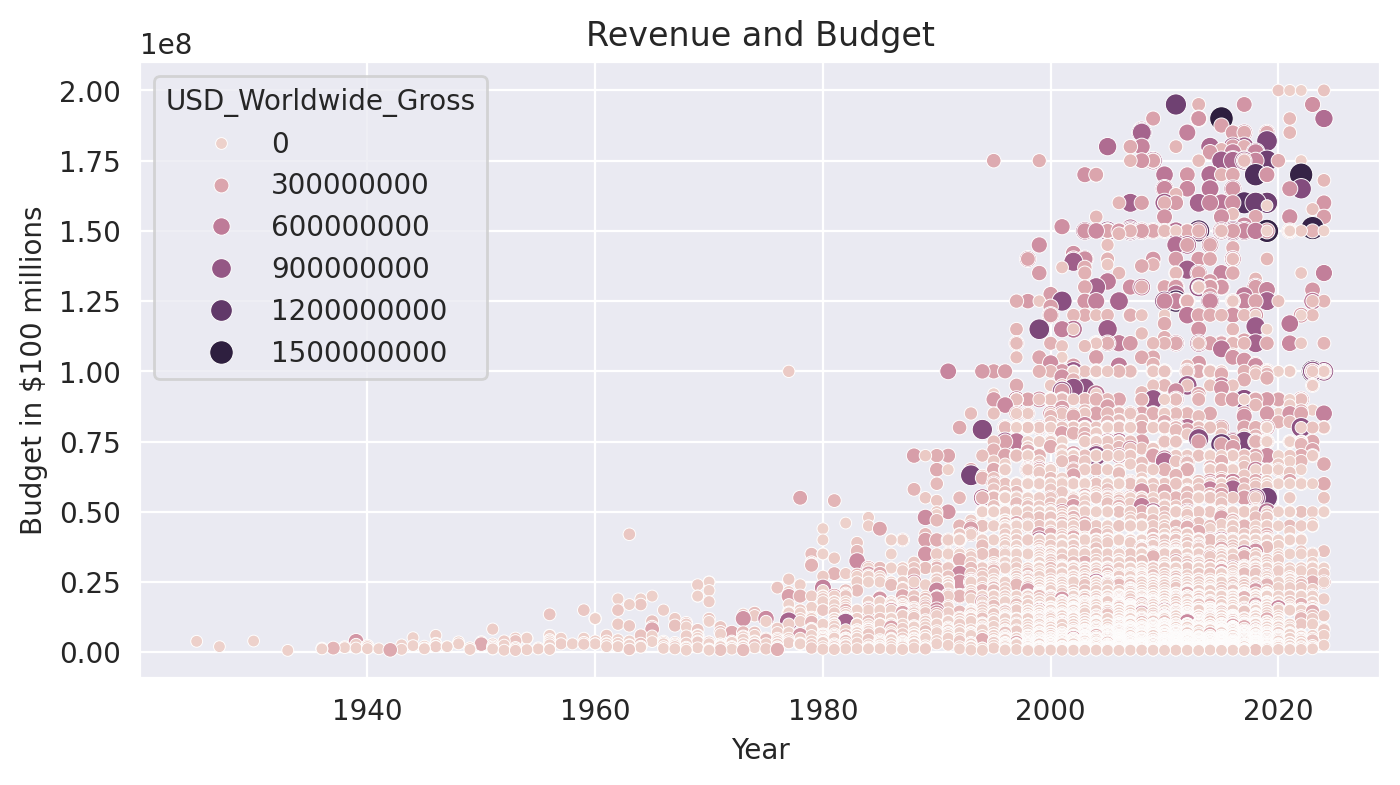

In [30]:
plt.figure(figsize=(8,4), dpi=200)
sns.set_style("darkgrid")
ax = sns.scatterplot(data=data_clean,
                     x=data_clean["Release_Date"].dt.year, 
                     y='USD_Production_Budget',
                     hue='USD_Worldwide_Gross', # colour
                     size='USD_Worldwide_Gross') # dot size
ax.set(ylabel='Budget in $100 millions',
       xlabel='Year',)
plt.title("Revenue and Budget")
plt.show()

In [31]:
data_clean["Decade"]=(data_clean["Release_Date"].dt.year//10)*10
data_clean.head()

,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Decade
0,2024-01-31,Argylle,200000000,45207275,96214128,2020
1,2020-09-04,Mulan,200000000,0,69973540,2020
2,2021-07-02,The Tomorrow War,200000000,0,19220000,2020
3,2022-07-13,The Gray Man,200000000,0,451178,2020
4,2011-06-29,Transformers: Dark of the Moon,195000000,352390543,1123794079,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [32]:
old_films=data_clean[data_clean['Decade']<=1969]
new_films=data_clean[data_clean['Decade']>=1970]

In [33]:
print(f"{old_films.shape[0]} films were released prior to 1970")
f"{old_films.loc[old_films.USD_Production_Budget.idxmax()].Movie_Title} was the most expensive film made prior to 1970"

142 films were released prior to 1970


'Cleopatra was the most expensive film made prior to 1970'

# Seaborn Regression Plots

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

Text(0.5, 1.0, 'Revenue from newly released movies')

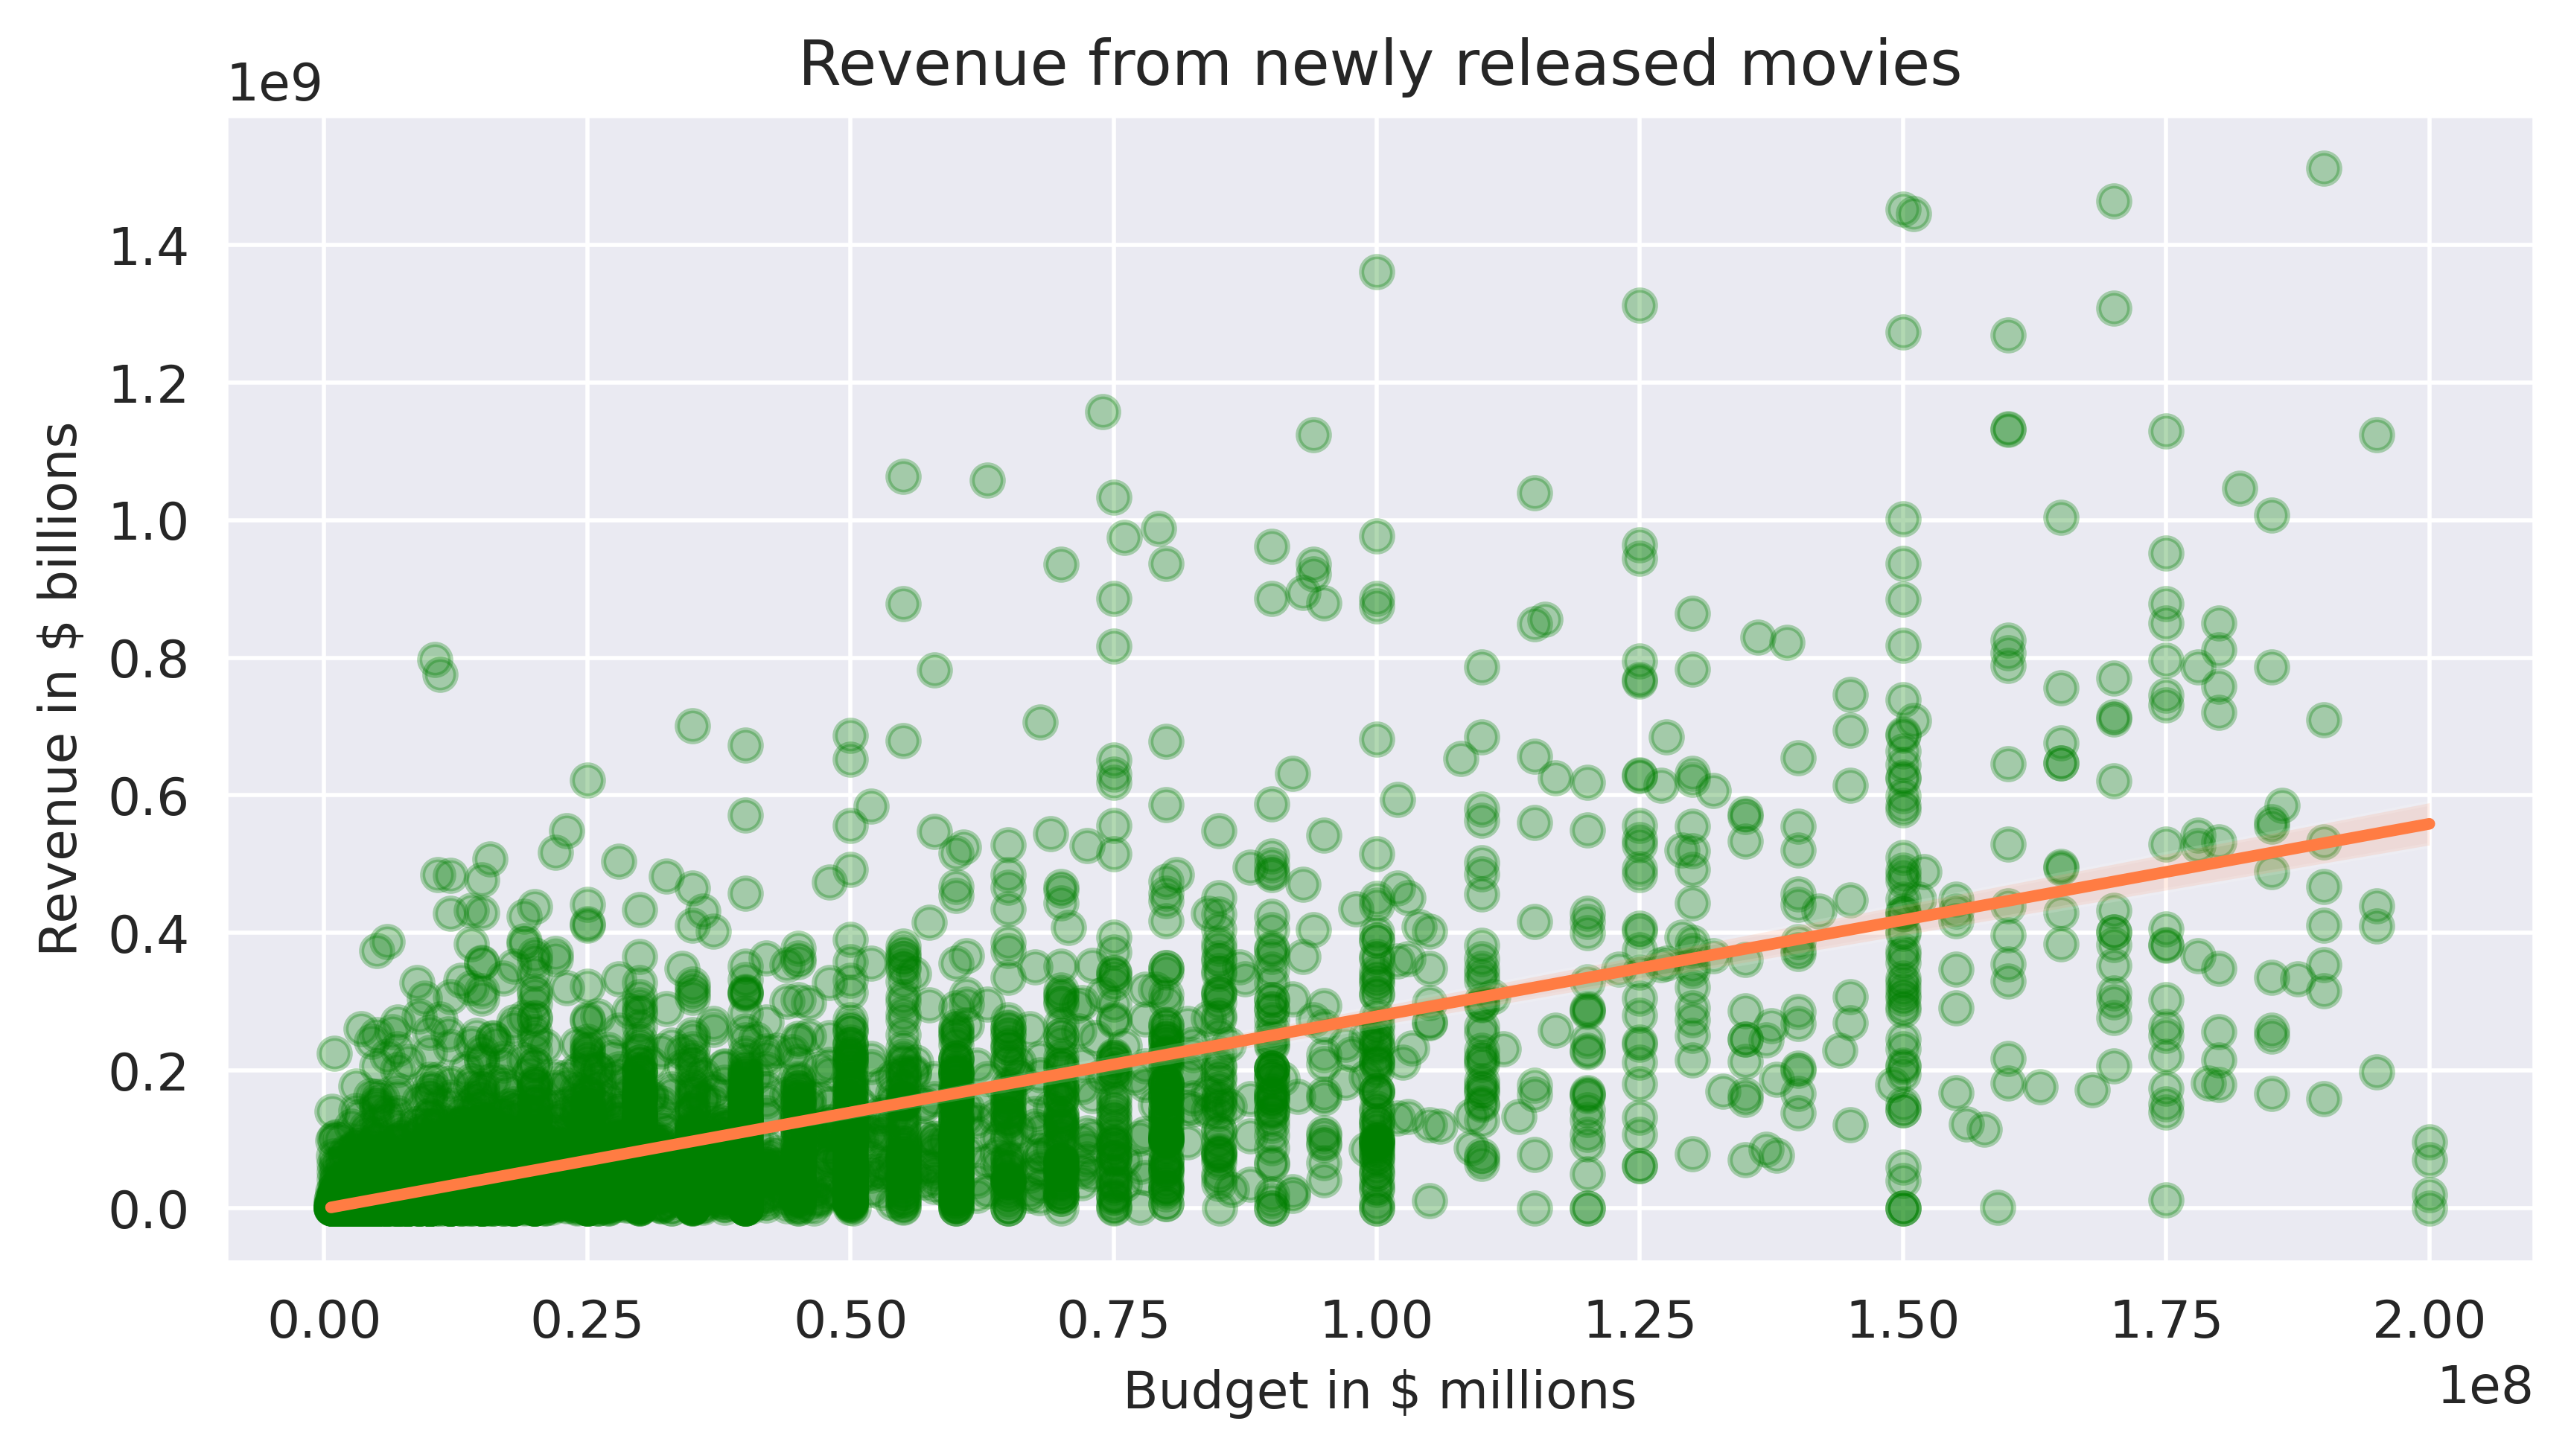

In [34]:
plt.figure(figsize=(8,4),dpi=500)
with sns.axes_style("darkgrid"):
    axes=sns.regplot(data=new_films,x="USD_Production_Budget",y="USD_Worldwide_Gross",scatter_kws={"color":"g",'alpha':0.3},line_kws={'color':'#ff7c43'})
    axes.set(xlabel="Budget in $ millions",ylabel="Revenue in $ billions")
plt.title("Revenue from newly released movies")

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [36]:
regression=LinearRegression()

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [57]:
# independent variable (features)
X=pd.DataFrame(old_films,columns=["USD_Production_Budget"])

# dependent vaiable (target)
Y=pd.DataFrame(old_films,columns=["USD_Worldwide_Gross"])

In [59]:
regression.fit(X=X,y=Y)

LinearRegression()

In [60]:
# slope
regression.coef_

array([[1.38691419]])

In [61]:
# y-intercept
regression.intercept_

array([25989000.48124406])

In [62]:
regression.score(X=X,y=Y)

0.01952029285775536

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [63]:
budget=350000000

In [64]:
theta_zero=regression.intercept_[0]

In [65]:
theta_one=regression.coef_[0,0]

In [81]:
revenue_estimate=theta_zero+(theta_one * budget)
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}')

The estimated revenue for a $350 film is around $511000000.0
